# Debug开启

In [1]:

import sys

# %matplotlib inline
%matplotlib widget
# stdi, stdo, stde = sys.stdin, sys.stdout, sys.stderr
# # # reload(sys)
# # # sys.setdefaultencoding('utf-8')
# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde

# stdout = sys.stdout
# sys.path.append('../')
# import JSONData.tdx_data_Day as tdd
# sys.stdout = stdout

# Delete Jupyter notebook root logger handler
# Set Debug
import logging

mylogger = logging.getLogger()
if len(mylogger.handlers) > 0:
    for ix in mylogger.handlers:
        print("handlers:%s std:%s" % (ix.stream, sys.stdout))
else:
    print("nb not handlers")
#     mylogger.propagate = False
mylogger.setLevel(logging.ERROR)
# mylogger.setLevel(logging.DEBUG)

print("nb:", sys.stderr)
# # Create logger as usual
import nest_asyncio
nest_asyncio.apply()

nb not handlers
nb: <ipykernel.iostream.OutStream object at 0x000002A1743D3490>


# TDX多日数据分析

## 定义 TDX-Path

In [2]:
# encoding:utf-8
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last_expr"

import sys

import pandas as pd
from pandas import HDFStore

stdi, stdo, stde = sys.stdin, sys.stdout, sys.stderr
# print(stdi, stdo, stde)
# reload(sys)
# sys.setdefaultencoding('utf-8')
# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde

# print(sys.stdout,sys.stderr,sys.stderr)

# print(stdi, stdo, stde)

# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde
# print(stdi, stdo, stde)

In [3]:
sys.path.append("../../")
import JSONData.tdx_data_Day as tdd
# import win_unicode_console
from JohnsonUtil import commonTips as cct
from JSONData import sina_data

# import nest_asyncio
# nest_asyncio.apply()
# 查阅资料后发现，发现使用 jupyter notebook 环境，其连接着 IPython 内核，而 IPython 内核本身在事件循环上运行，而 asyncio 不允许嵌套其事件​​循环，因此会出现如上图的错误信息。
# nest_asyncio 作为异步操作的补丁而存在，具体内容请参考
# win_unicode_console.disable()
tdx_path = "G:\\tdx_last_df.h5"
sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
sina_d_path = "G:\\sina_data.h5"
sina_dd_path = "G:\\get_sina_all_dd.h5"
# print(stdi, stdo, stde)
sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde

# # 显示所有列
pd.set_option("display.max_columns", None)
# # 显示所有行
# pd.set_option('display.max_rows', None)
# # 设置 value 的显示长度为 100，默认为 50
# pd.set_option('max_colwidth',100)
# pd.set_option?
# df.columns.tolist()

In [4]:
def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if root is None:
        root = store.keys()[0].replace("/", "")
    df = store[root]
    store.close()
    return df


def compute_perd_value(df, market_value=3, col="per"):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df


from collections import Counter, OrderedDict


def counterCategory(df):
    top5 = dict()
    if len(df) > 0:
        categoryl = df.category[:20].tolist()
        dicSort = []
        for i in categoryl:
            if isinstance(i, str):
                # dicSort.extend([ co.decode('utf8') for co in i.split(';')])
                dicSort.extend(i.split(';'))
                # cate_list = i.split(';')
                # for co in cate_list:
                #     dicSort.append(to_str(co))
        topSort = Counter(dicSort)
        top5 = OrderedDict(topSort.most_common(5))
        # for i in top5.keys():
        # print(i, top5[i]),
        # print('')
    return top5


def get_runtime_percent(df, perd=None):
    if "percent" not in df.columns and "lastp1d" in df.columns:
        # print('init percent')
        df['percent'] = list(
            map(
                lambda x, y, z: round((x - y) / y * 100, 1)
                if x != y else round((x - z) / z * 100, 1),
                df.close, df.lastp1d, df.lastp2d))
        # df['percent'] = df.apply(lambda x: round((x.close - x.lastp1d) /(x.lastp1d) * 100, 1),axis=1)
    # else:
    #     print('Percent in columns')
    if not perd is None:
        df[perd] = list(map(lambda x, y: round((x + y), 1)
                            if int(y) > 0 else 0, df.perd, df.percent))
    return df

## 还原Cell输出信息

In [5]:
# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde
# print(stdi, stdo, stde)

## 初始化 hdf5的tdx数据

In [6]:

market_value = "3"
df = readHdf5(tdx_path)
df = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
df = compute_perd_value(df, market_value, "perc")
df = compute_perd_value(df, market_value, "per")


# df=get_runtime_percent(df)

df = get_runtime_percent(df, "per%sd" % (market_value))

# filter 科创
df = clean_688(df)

df.shape
df[-1:].percent
df[~(df.last6vol > 0)][:10].last6vol

['/low_d_60_y_all', '/low_w_180_y_all']


ValueError: cannot convert float NaN to integer

## 个股数据查看

In [ ]:
df.loc[["603068", '601377', '000725'],
       ["date", "name", "category", "percent", "close", "lastp1d", "ma5d",
        "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
        "ra", "ral", "vcall", "vcra", "vchange", "lvol", 'lv', 'lowvol',
        'last6vol', 'per%sd' % (market_value),
        'perc%sd' % (market_value),
        'perc4d']][: 3]

In [ ]:

sort_key2 = "per%sd" % (market_value)
df = df.sort_values(
    by=["perc%sd" % (market_value), sort_key2, "fib"], ascending=[0, 0, 1]
)
df.loc[:,
       ["name", "category", "close", "percent","lastp1d", "ma5dcum", "ma20d", "fib",
        "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral", "per%sd" %
        (market_value),
        "perc%sd" % (market_value),
        sort_key2,],][: 5]

df.loc[:,
       ["name", "category", "close", "percent","lastp1d", "ma5dcum", "ma20d", "fib",
        "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral", "per%sd" %
        (market_value),
        "perc%sd" % (market_value),
        sort_key2,],][-5:]
# df = df.sort_values(by=['perc%sd'%(market_value), 'per%sd'%(market_value),'fib'],ascending=[0,0,1])

## filter 20D 涨幅榜 

In [ ]:
# df = df[(df['close'] > df['ma20d'] * 0.98) & (df['close'] < df['ma20d'] * 1.03)]
df = df[(df['close'] > df['ma20d'] * 0.98)
        & (df['df2'] > 0) & (df['lastp1d'] > df['ma5d']) & (df['lasth1d'] >= df['lasth2d']) ]

df.shape
df.loc[:, ["date", "name", "category", "close", "lastp1d", "ma5dcum", "ma20d",
       "fib", "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral", "vcall",
           "vcra", "vchange", "lvol", 'lv', 'lowvol', 'last6vol', 'per%sd' %
           (market_value),
           'perc%sd' % (market_value),
           'perc4d']][: 3]
df.loc[:, ["date", "name", "category", "close", "lastp1d", "ma5dcum", "ma20d",
       "fib", "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral", "vcall",
           "vcra", "vchange", "lvol", 'lv', 'lowvol', 'last6vol', 'per%sd' %
           (market_value),
           'perc%sd' % (market_value),
           'perc4d']][-3:]

In [ ]:

sort_key2 = "per%sd" % (market_value)

df = df.sort_values(
    by=[sort_key2, "perc%sd" % (market_value), "fib"], ascending=[0, 0, 1]
)
df.shape
df.loc[:,
       ["name", "category", "close", "percent","lastp1d", "ma5dcum", "ma20d",
        "fib", "fibl", "df2", "per1d", "hmax", "lmin", "per%sd" %
        (market_value),
        "perc%sd" % (market_value),
        sort_key2,],][: 5]

df.loc[:,
       ["name", "category", "close","percent", "lastp1d", "ma5dcum", "ma20d",
        "fib", "fibl", "df2", "per1d", "hmax", "lmin", "per%sd" %
        (market_value),
        "perc%sd" % (market_value),
        sort_key2,],][-5:]


# df.loc[:, ["name"]].T

In [ ]:
code = ["000725"]
df.loc[code,
       ["name", "close", "percent", "lastp1d", "ma5dcum", "ma20d", "fib",
        "fibl", "ra", "df2", "per1d", "hmax", "lmin", "per%sd" %
        (market_value),
        "perc%sd" % (market_value)]]

## Write code to blk 

# TDX参数数据信息

<AxesSubplot:xlabel='date'>

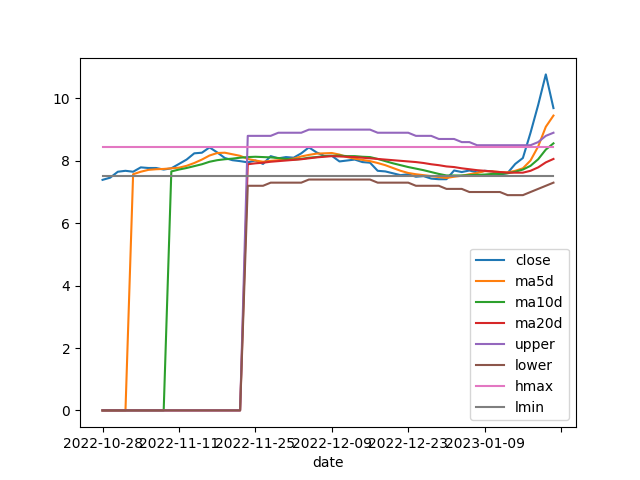

In [13]:
code = '002670'
tdf = tdd.get_tdx_Exp_day_to_df(code, dl=60).sort_index(ascending=True)
tdf.dropna(inplace=True)
tdf.loc[:, ["close" ,"ma5d", "ma10d",
            "ma20d", "upper", "lower", "hmax", "lmin"]].plot()
tdf = compute_perd_value(tdf, market_value, "per")

# 实时sina_MultiIndex 分析

## 初始化当日Multi

In [7]:
# ohlc_dict = {'open': 'first',
#              'high': 'max',
#              'low': 'min',
#              'close': 'last'}

ohlc_dict = {
    'volume': 'sum',
    'high': 'max',
    'low': 'min',
    'close': 'last'}


def minmax_norm(df):
    return ((df - df.min()) / (df.max() - df.min())).apply(lambda x: round(x, 2))

# def apply_round(df):
#     return df.apply(lambda x:round(x,2))


import pandas as pd
from pandas import HDFStore

# sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
# freq='30T'
# startime = '09:25:00'
# endtime = '15:01:00'
# def readHdf5(fpath, root=None):
#     store = pd.HDFStore(fpath, "r")
#     print((store.keys()))
#     if root is None:
#         root = list(store.keys())[0].replace("/", "")
#     df = store[root]
#     store.close()
#     return df

h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
h5.shape
# h5[:1]
code_muti = '600438'
h5.loc[code_muti][:2]
h5.loc[code_muti][-1:]

['/all_10']
G:\sina_MultiIndex_data.h5


(1216812, 6)

,close,high,low,llastp,volume,lastbuy
ticktime,,,,,,
2023-01-30 09:35:40,42.6,42.96,42.47,41.93,13012326,42.6
2023-01-30 09:36:19,42.6,42.96,42.47,41.93,13864726,42.6


,close,high,low,llastp,volume,lastbuy
ticktime,,,,,,
2023-01-30 13:42:31,41.74,42.96,41.64,41.93,64258997,41.96


In [8]:
h5_ohlc = h5.loc[code_muti, ['close', 'volume']]
h5_ohlc['low'] = h5_ohlc['close']
# h5_ohlc['open'] = h5_ohlc['close']
h5_ohlc['high'] = h5_ohlc['close']

h5_ohlc_30M = h5_ohlc.groupby(pd.Grouper(
    freq='30Min', closed='right', label='right')).agg(
    ohlc_dict).dropna()
# h5_ohlc_30M['volume'] = h5_ohlc_30M['volume'].apply(lambda x:round(x/100100,1))
h5_ohlc_30M['volume'] = minmax_norm(h5_ohlc_30M['volume'])
h5_ohlc_30M

,volume,high,low,close
ticktime,,,,
2023-01-30 10:00:00,0.00,42.62,42.35,42.52
2023-01-30 10:30:00,0.12,42.44,42.15,42.29
2023-01-30 11:00:00,0.78,42.22,41.89,41.97
2023-01-30 11:30:00,0.77,42.05,41.91,42.04
2023-01-30 13:30:00,1.00,41.96,41.70,41.76
2023-01-30 14:00:00,0.22,41.76,41.66,41.74


# 当日Sina数据分析

In [9]:
tdf = readHdf5(tdx_path)
tdf = tdd.get_sina_datadf_cnamedf(tdf.index.tolist(), tdf)
# tdf[ (tdf.last6vol > 0)].shape
tdf = clean_688(tdf)
# tdf[ (tdf.last6vol > 0)].shape
# market_value = '5'

# 统计连续数据
for i in range(9, 1, -1):
    # print(i),
    tdf = compute_perd_value(tdf, i, "perc")
    tdf = compute_perd_value(tdf, i, "per")
    # tdf = get_runtime_percent(tdf,"per%sd"%(i))

tdf = get_runtime_percent(tdf)

tdf[(tdf.last6vol > 0)].shape
tdf.loc[:, ['percent', 'perc1d', 'perc2d', 'perc3d', 'perc9d',
            'per1d', 'per2d', 'per3d', 'per9d']][:5]

['/low_d_60_y_all', '/low_w_180_y_all']


(4463, 111)

,percent,perc1d,perc2d,perc3d,perc9d,per1d,per2d,per3d,per9d
code,,,,,,,,,
159845,4.2,1.0,2.0,3.0,9.2,0.5,0.5,-0.5,3.6
510800,-7.8,1.1,1.1,1.0,1.8,1.5,1.5,0.0,-2.3
601313,9.9,1.1,2.2,3.2,9.3,10.0,20.0,21.6,26.6
159922,3.8,1.1,2.1,3.1,9.3,0.8,0.6,0.3,3.3
512510,4.0,1.0,2.0,3.0,9.2,0.6,0.6,0.0,3.2


## Sina_Data

In [10]:
sina = sina_data.Sina()
dd = sina.all
if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
    dd = dd[dd.close > 0]
else:
    dd = dd[dd.open > 0]

if 'percent' not in dd.columns:
    # print("compute percent")
    dd['percent'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                     100).map(lambda x: round(x, 2))

# dd.shape
dd.loc[:, ['percent', 'close']][:1]
dd = clean_688(dd)
print(dd.shape)
if 'nclose' in dd.columns:
    for co in ['nclose']:
        dd[co] = dd[co].apply(lambda x: round(x, 2))

# df.shape
# h5 = readHdf5(sina_MultiD_path)
# h5.shape
# h5[:1]
# tdf['last6vol'][:2]

# dd=cct.combine_dataFrame(dd, df['last6vol'])
# dd=cct.combine_dataFrame(dd, tdf['last6vol'], col=None, compare=None, append=False, clean=True)

,percent,close
code,,
300745,3.05,39.53


(4390, 41)


### 设置周期时间

In [11]:
tdf.loc[:, ['perc1d', 'perc2d', 'perc3d', 'perc9d',
            'per1d', 'per2d', 'per3d', 'per9d']][-5:]
# tdf = compute_perd_value(tdf, market_value, "perc")
# tdf = compute_perd_value(tdf, market_value, "per")

,perc1d,perc2d,perc3d,perc9d,per1d,per2d,per3d,per9d
code,,,,,,,,
300241,1.0,2.1,3.1,9.2,0.4,1.2,1.6,4.5
000859,1.1,2.2,3.2,9.1,0.7,2.0,2.5,2.2
300827,1.1,1.1,2.1,8.1,4.0,2.0,1.7,1.5
603601,1.0,2.0,3.0,9.1,-0.3,0.6,0.4,4.3
002291,1.1,1.1,2.0,8.0,3.2,2.6,-0.2,0.8


In [12]:
# dd=cct.combine_dataFrame(dd, tdf['last6vol'], col=None, compare=None, append=False, clean=True)
# dd.loc[:,['percent']][:1]
dd = cct.combine_dataFrame(
    dd, tdf, col=None, compare=None, append=False, clean=False)

dd.loc[:, ['percent']][:1]
dd[~(dd.last6vol > 0)].shape
# dd[:1]

,percent
code,
301398,3.84


(11, 149)

In [13]:
dd_clean = dd[~(dd.last6vol > 0)]
display(dd_clean.shape, dd_clean.index.tolist()[:5])
dd = dd[(dd.last6vol > 0)]
dd.shape

(11, 149)

['301398', '301317', '601136', '301301', '301368']

(4379, 149)

In [14]:
# display(dd_clean.shape, dd_clean.index)
# adf = df.copy()
# %timeit -r 5 adf['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
# %timeit -r 5 adf['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
# %timeit -r 5 adf['ene'] = map(lambda x, y: round((x + y) / 2, 1), adf.upper, adf.lower)

### 计算Vol Ratio倍率

In [15]:
# store = pd.HDFStore(sina_MultiD_path, "r")
# (store.keys())
# store.close()
# dd.columns
# dd.loc[:, ['open', 'llastp', 'nlow', 'low', 'nhigh', 'nhigh',
#        'low', 'volume', 'lastbuy','last6vol']][:1]
# dd.shape
time_ratio = cct.get_work_time_ratio()
time_ratio
dd['volra'] = list(map(lambda x, y: round((x / y), 1),
                       dd.volume / time_ratio, dd.last6vol))

dd.shape
dd[~(dd.volra > 0)].shape
dd.loc['301227', ['volra', 'vchange']]
# nldf.loc[:, ['close', 'nclose', 'llastp', 'open', 'nlow', 'low', 'nhigh',
#              'nhigh', 'low', 'volra', 'last6vol', 'volume', 'ticktime']][:2]

0.716

(4379, 150)

(0, 150)

volra       2.3
vchange    19.0
Name: 301227, dtype: object

### 突破左侧Hmax

In [17]:
# dz = dd[ ((dd.open > dd.llastp) | (dd.close > dd.nlow)) & (dd.close > dd.open) & ((dd.close > dd.hmax))].copy()
# dz = dd[  ((dd.lastl2d > dd.hmax)) & (dd.lastl2d >= dd.ma52d) ].copy()
dz = dd[((dd.close > dd.max5)) & (dd.close >= dd.ma20d)].copy()

market_value = 2

sort_key1 = "perc%sd" % (market_value)
sort_key2 = "per%sd" % (market_value)

# dz=get_runtime_percent(dz,"per%sd"%(market_value))
# 连阳排序
dz = dz.sort_values(
    by=[sort_key2, 'volra', sort_key1,
        "fib"],
    ascending=[0, 0, 0, 1])

dz.shape

dz.loc[:,
       ["name", "percent", 'volra', 'vchange', "perc%sd" % (market_value),
        sort_key2, "fib", "fibl", 'ra', 'ral', 'topR', 'top10', 'close',
        'lasth1d', 'hmax', 'lmin']][: 10].T

dz.loc[:,
       ["name", "percent", 'volra', 'vchange', "perc%sd" % (market_value),
        sort_key2, "fib", "fibl", 'ra', 'ral', 'topR', 'top10', 'close',
        'lasth1d', 'hmax', 'lmin']][-10:].T

(3001, 150)

code,001339,002848,600536,002808,002401,002380,600705,002777,601699,002651
name,智微智能,高斯贝尔,中国软件,恒久科技,中远海科,科远智慧,中航产融,久远银海,潞安环能,利君股份
percent,-0.0,-3.0,1.1,10.0,10.0,10.0,9.9,-4.4,-5.2,7.1
volra,26.2,18.6,4.5,2.2,1.4,1.3,1.9,13.1,3.6,5.0
vchange,72.5,246.7,19.9,2348.7,26.1,-55.9,22.8,37.1,241.8,109.4
perc2d,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2
per2d,20.0,20.0,20.0,20.0,20.0,20.0,18.2,16.7,14.6,13.7
fib,21.0,6.0,19.0,17.0,59.0,20.0,59.0,21.0,56.0,20.0
fibl,7.0,6.0,6.0,7.0,3.0,3.0,8.0,6.0,9.0,8.0
ra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ral,-0.6,-4.0,6.4,10.0,3.5,1.8,8.1,-0.1,4.6,3.0


code,300716,002686,301009,603330,000925,002161,601828,000026,002576,002678
name,国立科技,亿利达,可靠股份,天洋新材,众合科技,远 望 谷,美凯龙,飞亚达,通达动力,珠江钢琴
percent,2.5,2.5,1.6,6.4,3.1,7.8,2.2,7.8,10.0,10.0
volra,1.9,3.0,1.4,3.2,14.1,4.9,24.9,6.9,1.1,17.3
vchange,-34.3,-24.3,-48.5,-7.9,-52.0,-49.0,-37.1,-37.3,-18.0,101.0
perc2d,2.0,1.9,1.9,1.9,1.9,1.9,1.8,1.8,1.9,1.8
per2d,-5.3,-5.7,-5.9,-6.1,-8.1,-10.5,-11.2,-11.7,-12.6,-19.1
fib,55.0,20.0,59.0,59.0,20.0,20.0,58.0,59.0,20.0,59.0
fibl,9.0,8.0,9.0,8.0,8.0,8.0,9.0,6.0,9.0,6.0
ra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ral,-11.8,-16.5,-7.9,-11.3,-13.1,-10.2,-14.3,-15.0,-15.4,-22.1


### 原始数据排序 放量 

In [18]:
df = dd.copy()

market_value = 3

sort_key2 = "per%sd" % (market_value)

# 连阳排序
df = df.sort_values(
    by=[sort_key2, 'volra', 'vchange', "perc%sd" % (market_value),
        "fib"],
    ascending=[0, 0, 0, 0, 1])

df.shape

(4379, 150)

#### filter per3d >5

In [19]:
df = df[(df[sort_key2] > 5)]
df.shape

(415, 150)

In [20]:


# df = df[df.volra > 1.2]
# df = df[(df.volra > 1.5) & (df.volra < 5)]

display("KEY: perc%s %s ,%s" % (market_value, sort_key2, df.shape))

# 交易量排序
# df = df.sort_values(
#     by=['volra', "perc%sd" % (market_value),
#         sort_key2, "fib"],
#     ascending=[0, 0, 0, 1])


# 涨幅排序:
# df = df.sort_values(
#     by=[sort_key2,"perc%sd" % (market_value),'volra',
#          "fib"],
#     ascending=[0, 0, 0, 1])

df.loc[:, ['volra', 'perc%sd' % (market_value), sort_key2]][:2]
df.shape
df.loc[:,
       ["name", "category", 'percent', 'close', 'llastp', 'open',
        'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'vchange', 'last6vol',
        'volume', "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax",
        "lmin", "ra", "ral", "per%sd" % (market_value),
        "perc%sd" % (market_value),
        sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
        'per3d', 'per9d']][: 5]

df.loc[:,
       ["name", "category", 'percent', 'close', 'llastp', 'open',
        'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'vchange', 'last6vol',
        'volume', "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax",
        "lmin", "ra", "ral", "per%sd" % (market_value),
        "perc%sd" % (market_value),
        sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
        'per3d', 'per9d']][-5:]

# df.loc[:,
#        ["name", "category", "close", 'close', 'nclose', 'llastp', 'open',
#         'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume',
#         "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
#         "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']][-5:]

# '600536'  in df.index

'KEY: perc3 per3d ,(415, 150)'

,volra,perc3d,per3d
code,,,
002808,2.2,3.3,30.0
002401,1.4,3.3,30.0


(415, 150)

,name,category,percent,close,llastp,open,nlow,low,nhigh,nhigh,low,volra,vchange,last6vol,volume,ma5dcum,ma20d,fib,fibl,df2,per1d,hmax,lmin,ra,ral,per3d,perc3d,per3d,perc1d,perc2d,perc3d,perc9d,per1d,per2d,per3d,per9d
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
002808,恒久科技,\r,10.0,14.38,13.07,14.38,14.38,14.38,14.38,14.38,14.38,2.2,2348.7,2131400.0,3428776,8.7,8.39,17.0,7.0,7.0,10.0,13.07,7.41,0.0,10.0,30.0,3.3,30.0,1.1,2.2,3.3,9.5,10.0,20.0,30.0,54.3
002401,中远海科,MSCI潜力股;现代服务业;智,10.0,18.34,16.67,18.00,17.75,17.75,18.34,18.34,17.75,1.4,26.1,17238501.0,17736490,13.3,12.80,59.0,3.0,11.0,10.0,14.64,12.41,0.0,3.5,30.0,3.3,30.0,1.1,2.2,3.3,5.2,10.0,20.0,30.0,22.0
002777,久远银海,大数据;国产软件;智慧城市,-4.4,19.11,19.98,19.39,18.72,18.48,19.65,19.65,18.48,13.1,37.1,3733580.0,34928962,16.0,15.93,21.0,6.0,2.0,6.7,18.43,15.21,0.0,-0.1,26.7,3.3,26.7,1.1,2.2,3.3,6.2,6.7,16.7,26.7,24.0
600536,中国软件,国产软件;智慧党建;央企国资改,1.1,80.45,79.57,81.00,80.20,79.20,82.75,82.75,79.20,4.5,19.9,13458401.0,43238159,62.6,62.08,19.0,6.0,3.0,10.0,74.10,59.02,0.0,6.4,24.8,3.3,24.8,1.1,2.2,3.3,7.3,10.0,20.0,24.8,27.2
002848,高斯贝尔,数字电视;智能家居,-3.0,10.98,11.32,11.50,11.32,10.92,12.23,12.23,10.92,18.6,246.7,3370000.0,44994933,9.4,9.49,6.0,6.0,1.0,10.0,11.48,8.99,0.0,-4.0,21.3,3.2,21.3,1.1,2.2,3.2,7.2,10.0,20.0,21.3,17.3


,name,category,percent,close,llastp,open,nlow,low,nhigh,nhigh,low,volra,vchange,last6vol,volume,ma5dcum,ma20d,fib,fibl,df2,per1d,hmax,lmin,ra,ral,per3d,perc3d,per3d,perc1d,perc2d,perc3d,perc9d,per1d,per2d,per3d,per9d
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
600996,贵广网络,华为概念;智能家居;大数据,0.2,15.45,15.42,15.21,14.98,14.98,15.38,15.38,14.98,1.5,38.6,25677884.0,26957840,15.3,14.93,59.0,4.0,18.0,4.1,16.17,14.62,0.0,-9.5,5.1,1.2,5.1,1.1,0.1,1.2,2.1,4.1,2.0,5.1,-3.7
002532,天山铝业,节能环保;小额贷款;水利,3.1,8.91,8.91,9.00,8.78,8.78,9.05,9.05,8.78,1.5,15.7,21819798.0,23180241,8.3,8.12,59.0,6.0,6.0,3.1,8.53,7.87,0.0,2.5,5.1,3.2,5.1,1.1,2.1,3.2,9.3,3.1,3.8,5.1,9.2
000655,金岭矿业,铁矿石;地方国资改革;稀有金属,0.8,7.44,7.38,7.45,7.36,7.36,7.48,7.48,7.36,1.5,-5.7,5480700.0,5721700,6.9,6.83,58.0,9.0,0.0,1.0,7.32,6.75,0.0,-0.1,5.1,3.3,5.1,1.1,2.2,3.3,9.5,1.0,2.5,5.1,7.7
603738,泰晶科技,\r,-0.8,24.90,25.09,25.28,25.25,24.86,25.52,25.52,24.86,1.4,-33.9,5071960.0,5110217,23.1,22.18,59.0,9.0,5.0,-1.2,25.85,20.96,0.0,-4.6,5.1,3.2,5.1,1.0,2.1,3.2,9.3,-1.2,1.2,5.1,16.2
002068,黑猫股份,炭黑;新材料概念;地方国资改革,-0.1,14.44,14.45,15.00,14.50,14.36,15.01,15.01,14.36,1.3,-48.3,17760506.0,16960195,13.5,12.96,20.0,9.0,7.0,0.1,15.56,12.25,0.0,-10.5,5.1,3.1,5.1,1.0,2.1,3.1,9.2,0.1,4.2,5.1,13.1


### 高开高走数据排序前5 Volra <8

In [21]:


code_samp = '600771'

# if code_samp  in df.index:
#     df.loc[code_samp,['open','llastp','close','nclose','nlow','lasth1d','hmax','lmin','open','percent','fibl','ra','volra']]


if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
    df = dd[(dd.open > dd.llastp) & (dd.close > dd.nlow)
            & (dd.close > dd.open)].copy()
else:
    if not 'nclose' in dd.columns:
        df = dd[((dd.open >= dd.llastp)) &
                (dd.close > dd.open) & ((dd.percent > 1))].copy()
    else:
        df = dd[((dd.open > dd.llastp) | (dd.close > dd.nlow)) &
                (dd.close > dd.open)
                & ((dd.percent > 1) &
                 ((dd.close > dd.nclose) | (dd.close > dd.lasth1d))
                 & (dd.ra == 0)
                 & (dd.fibl > 1) )].copy()
        # df = dd[ ((dd.open > dd.llastp) | (dd.close > dd.nlow)) & (dd.close > dd.open) & ( (dd.percent > 1) & (dd.close > dd.lasth1d) & (dd.ra == 0))].copy()


market_value = 4
sort_key1 = "perc%sd" % (market_value)
sort_key2 = "per%sd" % (market_value)
# 连阳排序
df = df.sort_values(
    by=[sort_key1, 'volra', 'vchange',
        sort_key2, "fib"],
    ascending=[0, 0, 0, 0, 1])


# df = df[df.volra > 1.2]
# if not (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 1030):
#     df = df[(df.volra > 1.5) & (df.volra < 8)]

display("KEY: perc%sd %s ,%s" % (market_value, sort_key2, df.shape))

# 交易量排序
# df = df.sort_values(
#     by=['volra', "perc%sd" % (market_value),
#         sort_key2, "fib"],
#     ascending=[0, 0, 0, 1])


# if 'percent' not in df.columns:
#     print("compute percent")
#     df['percent'] = ((df['close'] - df['llastp']) / df['llastp'] * 100).map(lambda x: round(x, 2))

# 涨幅排序:
# df = df.sort_values(
#     by=[sort_key2,"perc%sd" % (market_value),'volra',
#          "fib"],
#     ascending=[0, 0, 0, 1])
dfbak = df.copy()
df = df[((df.close > df.max5)) & (df.close >= df.ma20d) &
        (df.volra >= 2) & (df.vchange >= 50)]

df.shape


df.loc[:, ['perc%sd' % (market_value), sort_key2]][:1]

df.loc[:,
       ["name", "percent", 'volra', 'vchange', "perc%sd" % (market_value),
        sort_key2, "volra", 'vchange', "fib", "fibl", 'ra', 'ral', 'topR',
        'top10', 'close', 'nclose', 'lasth1d', 'hmax', 'lmin']][: 20].T

df.loc[:,
       ["name", "percent", 'volra', 'vchange', "perc%sd" % (market_value),
        sort_key2, "volra", "fib", "fibl", 'ra', 'ral', 'topR', 'top10',
        'close', 'nclose', 'lasth1d', 'hmax', 'lmin']][-20:].T

# df.loc[:,
#        ["name", "category", 'close', 'nclose', 'llastp', 'open', 'nlow', 'low',
#         'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume', "ma5dcum",
#         "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral",
#         "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']][: 5]


# df.loc[:,
#        ["name", "category", "close", 'close', 'nclose', 'llastp', 'open',
#         'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume',
#         "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
#         "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']][-5:]

'KEY: perc4d per4d ,(1616, 150)'

(235, 150)

,perc4d,per4d
code,,
603909,4.4,4.2


code,603909,300112,300777,603261,300024,300183,002651,300455,603002,300862,603757,002376,603920,603181,600498,601677,000816,000612,000616,002075
name,建发合诚,万讯自控,中简科技,立航科技,机器人,东软载波,利君股份,康拓红外,宏昌电子,蓝盾光电,大元泵业,新北洋,世运电路,皇马科技,烽火通信,明泰铝业,智慧农业,焦作万方,ST海投,沙钢股份
percent,2.1,2.0,2.3,10.0,3.2,4.9,7.1,3.6,1.1,1.2,10.0,1.6,2.7,2.4,1.1,3.5,1.1,1.2,1.1,4.1
volra,3.5,3.5,3.4,9.5,8.8,6.7,5.0,4.9,4.4,4.3,4.2,4.2,4.0,3.4,3.3,3.0,3.0,2.9,2.0,11.2
vchange,73.9,66.4,164.1,96.7,458.4,55.2,109.4,106.4,50.1,187.8,70.0,52.2,142.5,70.6,66.0,83.7,59.0,122.6,58.5,163.5
perc4d,4.4,4.4,4.4,4.3,4.3,4.3,4.3,4.3,4.3,4.3,4.3,4.3,4.3,4.3,4.3,4.3,4.3,4.3,4.3,4.2
per4d,4.2,4.9,13.0,9.1,5.6,4.9,16.3,5.0,2.6,2.5,4.1,2.1,3.0,5.3,3.1,7.2,3.2,4.8,2.2,4.0
volra,3.5,3.5,3.4,9.5,8.8,6.7,5.0,4.9,4.4,4.3,4.2,4.2,4.0,3.4,3.3,3.0,3.0,2.9,2.0,11.2
vchange,73.9,66.4,164.1,96.7,458.4,55.2,109.4,106.4,50.1,187.8,70.0,52.2,142.5,70.6,66.0,83.7,59.0,122.6,58.5,163.5
fib,20.0,20.0,20.0,20.0,59.0,17.0,20.0,20.0,20.0,20.0,20.0,21.0,20.0,20.0,20.0,58.0,59.0,59.0,59.0,59.0
fibl,7.0,8.0,6.0,6.0,8.0,7.0,8.0,8.0,9.0,6.0,9.0,7.0,9.0,4.0,8.0,6.0,8.0,6.0,7.0,9.0


code,002437,002610,603880,600117,002496,002565,002598,002445,002481,603922,600636,600512,001313,603332,600186,000595,002599,002631,002090,603825
name,誉衡药业,爱康科技,南卫股份,西宁特钢,辉丰股份,顺灏股份,山东章鼓,中南文化,双塔食品,金鸿顺,国新文化,腾达建设,粤海饲料,苏州龙杰,莲花健康,宝塔实业,盛通股份,德尔未来,金智科技,华扬联众
percent,9.8,2.7,4.0,2.2,1.7,1.9,2.1,2.4,4.8,4.0,3.6,1.9,1.7,2.6,1.1,4.3,7.6,2.4,2.5,1.3
volra,6.9,4.6,4.2,3.1,3.1,3.1,3.0,2.8,6.7,6.3,5.1,3.8,3.4,2.9,2.6,4.9,4.2,3.9,3.0,2.3
vchange,55.4,51.1,51.8,97.7,95.6,72.2,77.0,51.5,97.8,123.9,66.3,95.3,93.5,71.4,56.5,52.0,84.5,80.5,67.2,147.9
perc4d,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9,0.9,0.9,0.9,0.0
per4d,1.7,1.1,1.5,2.5,1.8,0.7,1.5,1.3,0.0,0.9,3.2,1.2,0.0,0.6,0.9,-0.8,0.6,0.5,2.0,1.6
volra,6.9,4.6,4.2,3.1,3.1,3.1,3.0,2.8,6.7,6.3,5.1,3.8,3.4,2.9,2.6,4.9,4.2,3.9,3.0,2.3
fib,4.0,20.0,59.0,6.0,7.0,58.0,20.0,59.0,59.0,20.0,46.0,59.0,59.0,6.0,59.0,20.0,59.0,58.0,20.0,39.0
fibl,4.0,6.0,3.0,6.0,7.0,5.0,5.0,8.0,7.0,2.0,7.0,7.0,2.0,6.0,7.0,2.0,2.0,6.0,7.0,2.0
ra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:

name_loc = df.columns.get_loc("name")
perc_loc = df.columns.get_loc("percent")

# if code_samp  in df.index:
#     iloc = df.index.get_indexer_for((df[df.index == code_samp].index)).tolist()[0]
#     print("%s pos:%s percent:%s"%(df.iloc[iloc,name_loc],iloc,df.iloc[iloc,perc_loc]))
#     df.loc[code_samp,
#        ["name", "category","volra", "close", 'close', 'nclose', 'llastp', 'open',
#         'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume',
#         "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
#         "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']].T

### 优势板块统计

In [27]:
# df = df[df.high >= df.upper]

topSort = counterCategory(df)

# topSort.keys()

for i in topSort.keys():
    # print(u"板块:%s %s " % (i.decode('utf8'), (topSort[i]))),
    # print(u"板块:%s count:%s" % (i, (topSort[i]))),
    print(i, (topSort[i]))
    # print('')
    # unicode(i.encode('utf8'), 'utf-8').encode('utf-8')
    # unicode(i, 'utf-8').encode('gbk')
    # display(i.decode('utf8'))
    # (i.encode('utf8'))
    # (i.decode('unicode_escape'))
    # print((u'[' + u','.join((i.decode('utf8'))) + u']'))
df.shape
# print(repr(topSort.keys()).decode('unicode_escape'))
# df.loc[:,["name",]]

# topSort.keys()

新股与次新股 4
军工  2
节能环保 2
军工 2
涉矿 2


(235, 150)

###   高开高走VOl 1.5-6 

In [28]:


filter_day = '1'

if filter_day < str(2):
    # print(filter_day)
    df = df[(df.lasth1d >= df.upper) & (
        df.close > df.ma20d) & (df.ma5d > df.ma20d)]
else:
    df = df[(df['lastp%sd' % (filter_day)] >= df.upper) &
            (df['lastp%sd' % (filter_day)] > df['ma20%sd' % (filter_day)]) &
            (df['ma5%sd' % (filter_day)] > df['ma20%sd' % (filter_day)])]

topSort = counterCategory(df)

for i in topSort.keys():
    # print("板块:%s %s " % (i, (topSort[i]))),
    print(i, (topSort[i]))
    # print('')
    # unicode(i.encode('utf8'), 'utf-8').encode('utf-8')
    # unicode(i, 'utf-8').encode('gbk')
    # display(i.decode('utf8'))
    # (i.encode('utf8'))
    # (i.decode('unicode_escape'))
    # print((u'[' + u','.join((i.decode('utf8'))) + u']'))
df.shape
# print(repr(topSort.keys()).decode('unicode_escape'))
# df.loc[:,["name",]]

# topSort.keys()

新股与次新股 3
军工  2
高端装备 2
军工 2
新股 2


(17, 150)

In [32]:
# df.loc[:,
#        ["name", "category",'close','nclose', 'llastp','open', 'nlow', 'low', 'nhigh', 'nhigh',
#        'low',  'lastbuy','volra','last6vol','volume', "ma5dcum", "ma20d", "fib",
#         "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral", "per%sd" %
#         (market_value),
#         "perc%sd" % (market_value),
#         sort_key2,],]

df.loc[:,
       ['name', "category", 'vchange', "ma5dcum", 'lastp%sd' % (filter_day),
        'ma5%sd' % (filter_day),
        'ma20%sd' % (filter_day),
        "fib", "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral", "per%sd" %
        (market_value),
        "perc%sd" % (market_value),
        sort_key2]][: 10].T

df.loc[:,
       ['name', "category", 'vchange', "ma5dcum", "ma20d", "fib", "fibl",
        "df2", "per1d", "hmax", "lmin", "ra", "ral", "per%sd" %
        (market_value),
        "perc%sd" % (market_value),
        sort_key2]][-5:]

code,300777,603261,300024,002651,300853,000972,002134,601728,000831,603516
name,中简科技,立航科技,机器人,利君股份,申昊科技,ST中基,天津普林,中国电信,中国稀土,淳中科技
category,军工 ;碳纤维 ;新股与次新股,军工 ;大飞机 ;新股与次新股,电梯物联网;参股保险;高端装备,航天军工;节能环保;军工,机器人概念 ;智能电网 ;新股,ST板块;新疆建设兵团;新疆振,债转股;滨海新区;地方国资改革,5G运营商 ;央企国资改革 ;,阿里巴巴概念;稀土整合;MSC,安防;新股与次新股;军工
vchange,164.1,96.7,458.4,109.4,338.2,79.1,111.7,551.6,504.8,89.2
ma5dcum,50.0,34.9,9.2,7.1,24.3,3.6,8.8,4.4,34.7,15.1
lastp1d,56.69,38.29,9.77,8.51,25.39,4.02,9.29,4.85,38.51,15.86
ma51d,52.61,36.26,9.4,7.79,24.87,3.82,9.07,4.46,35.66,15.76
ma201d,49.89,34.99,9.18,6.94,23.63,3.32,8.59,4.34,34.41,14.5
fib,20.0,20.0,59.0,20.0,16.0,58.0,16.0,48.0,59.0,59.0
fibl,6.0,6.0,8.0,8.0,9.0,9.0,9.0,3.0,9.0,9.0
df2,1.0,1.0,1.0,5.0,1.0,13.0,1.0,3.0,1.0,5.0


,name,category,vchange,ma5dcum,ma20d,fib,fibl,df2,per1d,hmax,lmin,ra,ral,per4d,perc4d,per4d
code,,,,,,,,,,,,,,,,
300080,易成新能,太阳能;新能源;碳化硅,113.9,5.3,5.06,20.0,9.0,6.0,3.5,5.58,4.95,0.0,-1.0,4.6,4.1,4.6
300532,今天国际,智能物流;高送转,118.3,16.3,15.72,38.0,9.0,4.0,-2.0,19.64,15.53,0.0,-16.6,0.6,4.0,0.6
300044,赛为智能,人脸识别;在线教育;绿色建筑,363.2,2.9,2.93,16.0,6.0,1.0,6.1,3.74,2.85,0.0,-18.2,7.5,3.2,7.5
300271,华宇软件,依法治国概念;SAAS;二维码,180.9,7.3,7.19,39.0,7.0,1.0,6.1,7.68,7.02,0.0,1.3,8.8,3.2,8.8
300941,创识科技,融资融券 ;转融券标的 ;新股,124.8,21.6,20.80,16.0,3.0,1.0,4.4,24.58,20.87,0.0,-7.5,6.5,3.1,6.5


In [30]:
df.loc[code_samp,
       ["name", "category", "volra", 'vchange', "close", 'close', 'nclose',
        'llastp', 'open', 'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra',
        'last6vol', 'volume', "ma5dcum", "ma20d", "fib", "fibl", "df2",
        "per1d", "hmax", "lmin", "ra", "ral", "per%sd" % (market_value),
        "perc%sd" % (market_value),
        sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
        'per3d', 'per9d']].T

KeyError: '600771'

In [31]:
# VectorBT 回测

import vectorbt as vbt

# Matplotlib Scatter Plot
plt.scatter(‘total_bill’, ‘tip’,data=df.close)
plt.xlabel(‘Total Bill’)
plt.ylabel(‘Tip’)
plt.show()

In [70]:
tdf.shape
tdf.loc[:,
        ["close", "ma5d", "ma10d", "ma20d", "upper", "lower", "lastp1d",
         "ma5dcum", "ma20d", "fib", "fibl", "ra", "df2", "per1d", "hmax",
         'lmin', "per%sd" % (market_value),
         "perc%sd" % (market_value),
         sort_key2,]][-1:]
# df.columns

(4357, 111)

,close,ma5d,ma10d,ma20d,upper,lower,lastp1d,ma5dcum,ma20d,fib,fibl,ra,df2,per1d,hmax,lmin,per4d,perc4d,per4d
code,,,,,,,,,,,,,,,,,,,
600552,10.16,9.86,9.66,9.52,10.6,8.7,10.16,9.6,9.52,59.0,6.0,0.0,0.0,0.0,11.03,9.26,6.7,4.1,6.7


In [79]:
tdf[tdf.columns[(tdf.columns >= "per1d") & (tdf.columns <= "per9d")]][-1:]
tdf[tdf.columns[(tdf.columns >= "perc1d") & (tdf.columns <= "perc9d")]][-1:]

,per1d,per2d,per3d,per4d,per5d,per6d,per7d,per8d,per9d
date,,,,,,,,,
2023-01-20,-10.0,10.0,10.0,10.0,2.4,3.8,0.7,-1.3,-0.3


,perc1d,perc2d,perc3d,perc4d,perc5d,perc6d,perc7d,perc8d,perc9d
date,,,,,,,,,
2023-01-20,0.9,1.1,1.1,1.1,1.1,1.1,1.0,0.9,1.0


In [80]:
tdf[tdf.columns[(tdf.columns >= "per1d") & (tdf.columns <= "per9d")]][:1]
tdf[tdf.columns[(tdf.columns >= "perc1d") & (tdf.columns <= "perc9d")]][:1]

,per1d,per2d,per3d,per4d,per5d,per6d,per7d,per8d,per9d
date,,,,,,,,,
2022-10-28,-10.0,10.0,10.0,10.0,2.4,3.8,0.7,-1.3,-0.3


,perc1d,perc2d,perc3d,perc4d,perc5d,perc6d,perc7d,perc8d,perc9d
date,,,,,,,,,
2022-10-28,0.9,1.1,1.1,1.1,1.1,1.1,1.0,0.9,1.0


<AxesSubplot:xlabel='date'>

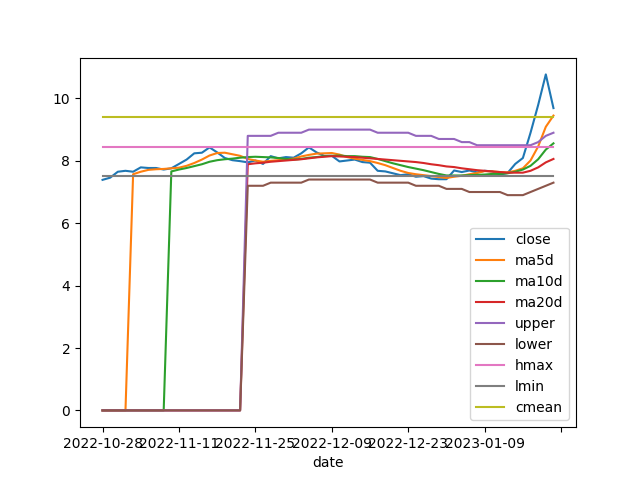

In [82]:

tdf = tdd.get_tdx_Exp_day_to_df(code, dl=60).sort_index(ascending=True)
# cname = tdd.get_sina_data_code(code)
# plt.title(
#     stock_code + " | " + cname + " | " + str(quotes.index[-1])[: 10],
#     fontsize=14)
tdf.loc[:, ["close", "ma5d", "ma10d", "ma20d",
            "upper", "lower", "hmax", 'lmin', 'cmean']].plot()

In [83]:
tdf[tdf.columns[(tdf.columns >= "perc1d") & (tdf.columns <= "perc9d")]][-1:]

,perc1d,perc2d,perc3d,perc4d,perc5d,perc6d,perc7d,perc8d,perc9d
date,,,,,,,,,
2023-01-20,0.9,1.1,1.1,1.1,1.1,1.1,1.0,0.9,1.0


In [84]:
tdf[tdf.columns[(tdf.columns >= "per1d") & (tdf.columns <= "per9d")]][-1:]

,per1d,per2d,per3d,per4d,per5d,per6d,per7d,per8d,per9d
date,,,,,,,,,
2023-01-20,-10.0,10.0,10.0,10.0,2.4,3.8,0.7,-1.3,-0.3
